In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
import yaml
import math
from pyramid import create_pyramid
from continuous_maze import bfs, get_trajectories, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss
import os
import time
from train_streets import get_maze

import numpy as np

In [84]:
def contrastive_loss(feature1_embed, feature2_embed, temperature):
    logits = torch.matmul(feature1_embed, feature2_embed.t()) / temperature
    labels = torch.arange(feature1_embed.shape[0], device=feature1_embed.device)
    loss_1 = F.cross_entropy(logits, labels)
    loss_2 = F.cross_entropy(logits.t(), labels)
    return (loss_1 + loss_2) / 2

class PointCloudEncoder(nn.Module):
    def __init__(self, input_dim=8, output_dim=256):
        super(PointCloudEncoder, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.linear1 = nn.Linear(256, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, output_dim)

    def forward(self, x):
        # x shape: (batch_size, n, 8)
        x = x.transpose(2, 1)  # (batch_size, 8, n)
        
        # Point-wise MLPs
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        
        # Max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 256)
        
        # Fully connected layers
        x = F.relu(self.bn4(self.linear1(x)))
        x = self.linear2(x)
        
        return x

class SetDataset(Dataset):
    def __init__(self, maze, num_trajectories, embedding_dim=2, num_negatives=10, gamma=0.1, order_fn=None, num_splits=4):
        super().__init__()
        self.num_trajectories = num_trajectories
        self.num_negatives = num_negatives
        self.num_splits = num_splits
        self.maze = maze
        self.gamma = gamma
        print(f'gamma: {self.gamma}')

        self.trajectories = get_trajectories(maze, num_trajectories, order_fn=order_fn)

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        # Anchor: the current data point
        
        traj = self.trajectories[idx]
        split_traj = np.split(traj, np.random.randint(0, len(arr), size=self.num_splits))
        split_traj = list(filter(lambda x: x.shape[0] != 0,split_traj))
        # print(split_traj)
        
        i, j = np.random.randint(0, len(split_traj), 2)
        # print(i, j)
        set1 = [x[0] for x in split_traj[i]]
        set2 = [x[0] for x in split_traj[j]]
        
        return set1, set2

In [124]:
class PointCloudEncoder(nn.Module):
    def __init__(self, input_dim=8, output_dim=256):
        super(PointCloudEncoder, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.linear1 = nn.Linear(256, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, output_dim)

    def forward(self, x):
        # x shape: (batch_size, n, 8)
        x = x.transpose(2, 1)  # (batch_size, 8, n)
        
        # Point-wise MLPs
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        
        # Max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 256)
        
        # Fully connected layers
        x = F.relu(self.bn4(self.linear1(x)))
        x = self.linear2(x)
        
        return x

# Example usage
batch_size = 32
n_points = 12  # This can vary
input_dim = 2
output_dim = 256

encoder = PointCloudEncoder(input_dim=input_dim, output_dim=output_dim)

# Generate random point cloud data
point_cloud = torch.randn(batch_size, n_points, input_dim)
print(point_cloud.shape)
# Encode the point cloud
encoded = encoder(point_cloud)
print(encoded.shape)  # Should be (batch_size, output_dim)

torch.Size([32, 12, 2])
torch.Size([32, 256])


In [113]:
maze = get_maze('blank')

ds = SetDataset(maze, 1000, num_splits=4)

ds[0]

blank maze
gamma: 0.1


([array([3.5, 8.5])], [array([3.5, 8.5])])

[array([6.51748532, 2.50117886]), array([6.03871404, 2.35703289]), array([5.56067249, 2.50358077]), array([5.0619634 , 2.46767484]), array([4.57035556, 2.55889836]), array([4.07670684, 2.63833982]), array([3.64179774, 2.39165363])]
---------
[array([8.5, 3.5]), array([8.32343346, 3.03221345]), array([8.45999208, 2.55122307]), array([7.96097744, 2.58259807]), array([7.50751388, 2.37195429]), array([7.00887073, 2.40876473])]


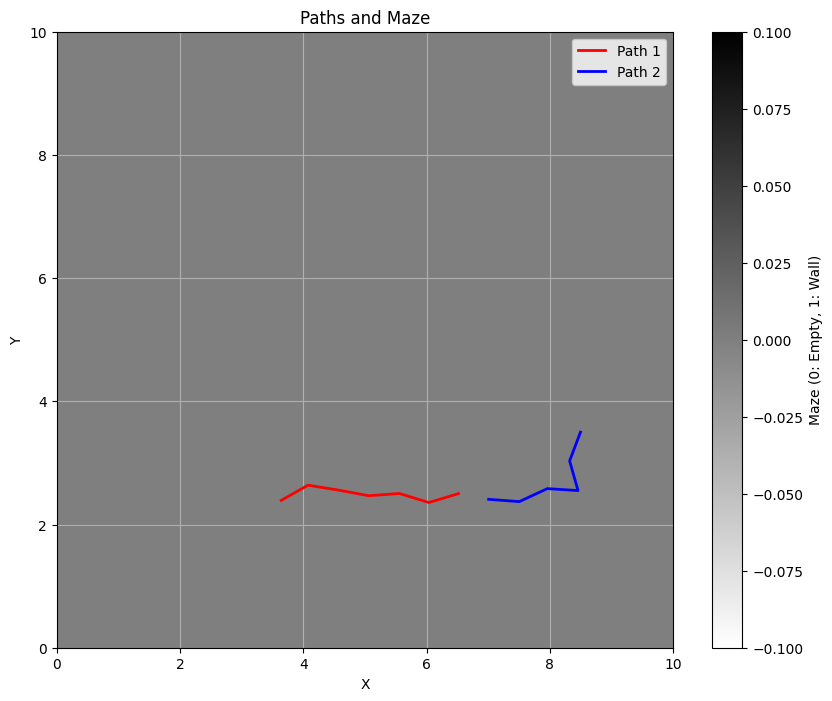

In [117]:
import numpy as np
import matplotlib.pyplot as plt

def plot_paths_and_maze(maze, paths):
    # Extract x and y coordinates from the paths
    x1, y1 = zip(*paths[0])
    x2, y2 = zip(*paths[1])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the maze
    maze_image = ax.imshow(maze, cmap='binary', origin='lower', extent=[0, maze.shape[1], 0, maze.shape[0]])

    # Plot the paths
    ax.plot(x1, y1, 'r-', linewidth=2, label='Path 1')
    ax.plot(x2, y2, 'b-', linewidth=2, label='Path 2')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Paths and Maze')

    # Add legend
    ax.legend()

    # Show the plot
    plt.colorbar(maze_image, label='Maze (0: Empty, 1: Wall)')
    plt.grid(True)
    plt.show()

paths = ds[np.random.randint(0, 100)]
print(paths[0])
print('---------')
print(paths[1])
plot_paths_and_maze(maze, paths)

In [83]:
ds[0]

([7.4638674278350345,
  7.5598638170644294,
  7.524388512776824,
  7.031784649267966,
  6.534814322114223,
  6.737251654064183,
  6.580255999731444,
  6.502078453754112,
  6.416796019200024,
  6.4741794369140235,
  6.60815072751397,
  6.116627841984628,
  5.653586755719245,
  5.442442770924813,
  5.25538190976897,
  5.3705313972171895,
  5.576891139709331,
  5.079216485680033,
  4.580665315033116,
  4.0811599112232,
  3.6248620385059205],
 [7.4638674278350345,
  7.5598638170644294,
  7.524388512776824,
  7.031784649267966,
  6.534814322114223])

In [22]:
arr = np.array([1,2,3,4,5,6,7,8])

split_arr = np.split(arr, np.random.randint(0, len(arr), size=100))
print(split_arr)
split_arr[1]

[array([1, 2]), array([], dtype=int64), array([2, 3, 4, 5]), array([], dtype=int64), array([], dtype=int64), array([4, 5, 6]), array([7]), array([], dtype=int64), array([], dtype=int64), array([1, 2]), array([], dtype=int64), array([2]), array([3, 4, 5, 6, 7]), array([], dtype=int64), array([2, 3, 4]), array([5, 6, 7]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([1, 2, 3, 4, 5, 6, 7]), array([], dtype=int64), array([1, 2, 3, 4, 5]), array([6]), array([], dtype=int64), array([], dtype=int64), array([1, 2, 3, 4, 5, 6]), array([], dtype=int64), array([1, 2, 3, 4]), array([], dtype=int64), array([1, 2]), array([], dtype=int64), array([], dtype=int64), array([1, 2, 3, 4]), array([], dtype=int64), array([2, 3]), array([4, 5, 6, 7]), array([], dtype=int64), array([5, 6]), array([7]), array([], dtype=int64), array([5, 6]), array([], dtype=int64), array([3, 4, 5, 6, 7]), array([], dtype=int64), array([1, 2, 3, 4, 5, 6]), array([7]), array([], dtype=int64), arr

array([], dtype=int64)

In [28]:
np.array([1,2]).shape[0] == 0

False

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Dataset
class FakeContrastiveDataset(Dataset):
    def __init__(self, num_samples, feature1_dim, feature2_dim):
        self.num_samples = num_samples
        self.feature1_dim = feature1_dim
        self.feature2_dim = feature2_dim
        
        self.base_data = np.random.randn(num_samples, max(feature1_dim, feature2_dim))
        self.transform1 = np.random.randn(max(feature1_dim, feature2_dim), feature1_dim)
        self.transform2 = np.random.randn(max(feature1_dim, feature2_dim), feature2_dim)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base = self.base_data[idx]
        feature1 = np.dot(base, self.transform1)
        feature2 = np.dot(base, self.transform2)
        return torch.FloatTensor(feature1), torch.FloatTensor(feature2)

# Network
class ContrastiveNetwork(nn.Module):
    def __init__(self, feature1_dim, feature2_dim, embed_dim):
        super().__init__()
        self.feature1_proj = nn.Linear(feature1_dim, embed_dim)
        self.feature2_proj = nn.Linear(feature2_dim, embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, feature1, feature2):
        feature1_embed = F.normalize(self.feature1_proj(feature1), dim=-1)
        feature2_embed = F.normalize(self.feature2_proj(feature2), dim=-1)
        return feature1_embed, feature2_embed, self.logit_scale.exp()

# Loss Function


# Hyperparameters
num_samples = 10000
feature1_dim = 128
feature2_dim = 256
embed_dim = 64
batch_size = 256
num_epochs = 10
learning_rate = 1e-4

# Create dataset and dataloader
dataset = FakeContrastiveDataset(num_samples, feature1_dim, feature2_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize network
network = ContrastiveNetwork(feature1_dim, feature2_dim, embed_dim)

# Optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for batch, (feature1, feature2) in enumerate(dataloader):
        feature1, feature2 = feature1.to(device), feature2.to(device)
        
        # Forward pass
        feature1_embed, feature2_embed, logit_scale = network(feature1, feature2)
        
        # Compute loss
        loss = contrastive_loss(feature1_embed, feature2_embed, logit_scale)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        if (batch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("Training finished!")

Epoch [1/10], Batch [10/40], Loss: 6.8387
Epoch [1/10], Batch [20/40], Loss: 6.4517
Epoch [1/10], Batch [30/40], Loss: 6.2696
Epoch [1/10], Batch [40/40], Loss: 3.4603
Epoch [1/10], Average Loss: 6.4178
Epoch [2/10], Batch [10/40], Loss: 5.4550
Epoch [2/10], Batch [20/40], Loss: 5.3014
Epoch [2/10], Batch [30/40], Loss: 4.8492
Epoch [2/10], Batch [40/40], Loss: 2.0466
Epoch [2/10], Average Loss: 5.1548
Epoch [3/10], Batch [10/40], Loss: 4.4907
Epoch [3/10], Batch [20/40], Loss: 4.0099
Epoch [3/10], Batch [30/40], Loss: 3.8374
Epoch [3/10], Batch [40/40], Loss: 1.0120
Epoch [3/10], Average Loss: 4.0478
Epoch [4/10], Batch [10/40], Loss: 3.4929
Epoch [4/10], Batch [20/40], Loss: 3.2651
Epoch [4/10], Batch [30/40], Loss: 2.9943
Epoch [4/10], Batch [40/40], Loss: 0.8107
Epoch [4/10], Average Loss: 3.1029
Epoch [5/10], Batch [10/40], Loss: 2.4051
Epoch [5/10], Batch [20/40], Loss: 2.4578
Epoch [5/10], Batch [30/40], Loss: 2.1044
Epoch [5/10], Batch [40/40], Loss: 0.3815
Epoch [5/10], Averag